# Remembering the Past with LSTM

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
print(tf.__version__)

2.13.1


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## LSTM
### Single-step model

In [11]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [12]:
# Values obtained from chapter 14

mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [13]:
# Define the LSTM model architecture
lstm_model = Sequential([  # Initialize the Sequential model
    LSTM(32, return_sequences=True),  # Add an LSTM layer with 32 units, True makes sure that past information is being used by the network
    Dense(units=1)                    # Add a Dense output layer with 1 unit (for a single prediction output)
])

# Compile and fit the model using the custom 'compile_and_fit' function, passing the wide_window training data
history = compile_and_fit(lstm_model, wide_window)

# Initialize dictionaries to store validation and performance results
val_performance = {}  # Dictionary to store validation performance for each model
performance = {}      # Dictionary to store test performance for each model

# Evaluate the model on the validation dataset and store the result in the 'val_performance' dictionary
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)  

# Evaluate the model on the test dataset and store the result in the 'performance' dictionary
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 11s 16ms/step - loss: 0.0379 - mean_absolute_error: 0.1350 - val_loss: 0.0131 - val_mean_absolute_error: 0.0828
Epoch 2/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0085 - mean_absolute_error: 0.0656 - val_loss: 0.0061 - val_mean_absolute_error: 0.0559
Epoch 3/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0055 - mean_absolute_error: 0.0525 - val_loss: 0.0045 - val_mean_absolute_error: 0.0481
Epoch 4/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0045 - mean_absolute_error: 0.0476 - val_loss: 0.0040 - val_mean_absolute_error: 0.0458
Epoch 5/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0040 - mean_absolute_error: 0.0447 - val_loss: 0.0035 - val_mean_absolute_error: 0.0420
Epoch 6/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0037 - mean_absolute_error: 0.0426 - val_loss: 0.0032 - val_mean_absolute_error: 0.0403
Epoch 7/5

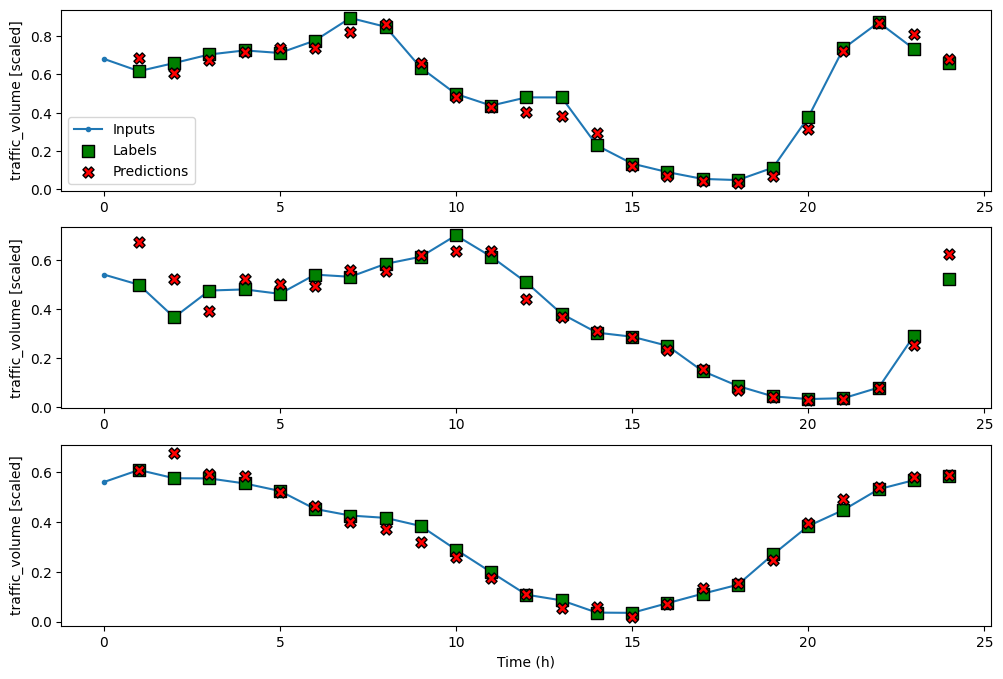

In [14]:
wide_window.plot(lstm_model)

*Predicting traffic volume using an LSTM as a single-step model. Many predictions (shown as
crosses) overlap the labels (shown as squares), suggesting we have a performant model with accurate
predictions.*

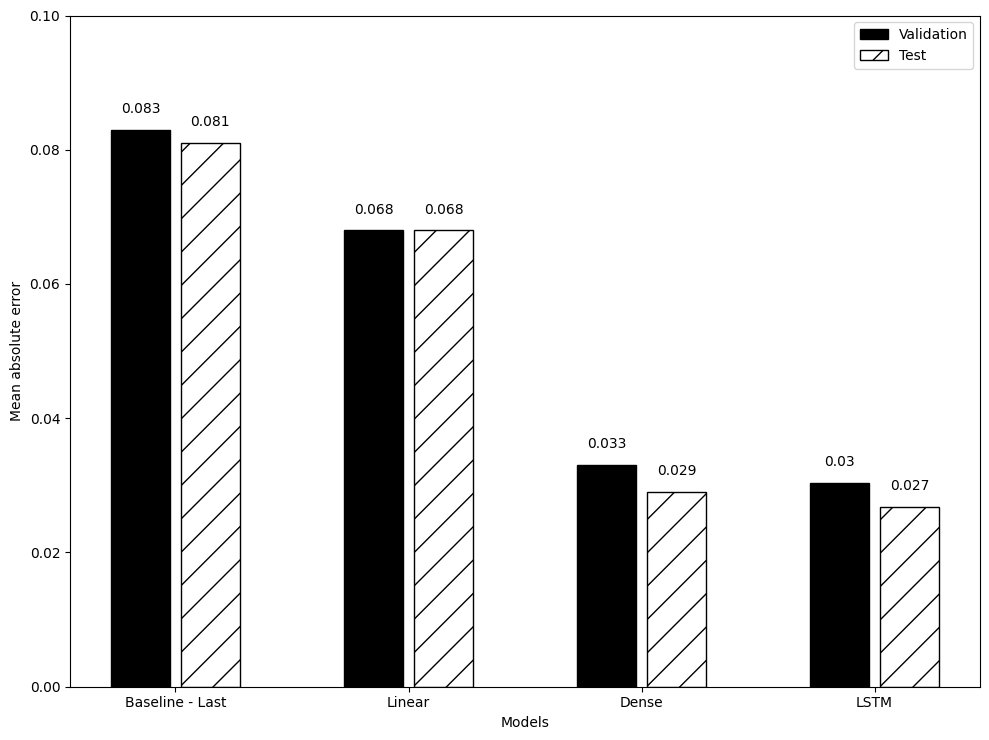

In [16]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

*Mean absolute error (MAE) of all single-step models built so far. For now, the LSTM is the
winning model, since it has the lowest MAE on both the validation and test sets.*

### Multi-step model

In [19]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [20]:
# Values obtained from chapter 14

ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [21]:
# Define the LSTM model architecture for multi-step prediction
ms_lstm_model = Sequential([                             # Initialize the Sequential model
    LSTM(32, return_sequences=True),                     # Add an LSTM layer with 32 units, and set 'return_sequences=True' to return the full sequence
    Dense(1, kernel_initializer=tf.initializers.zeros),  # Add a Dense output layer with 1 unit, initialized with zeros
])

# Compile and fit the model using the custom 'compile_and_fit' function, passing the multi_window training data
history = compile_and_fit(ms_lstm_model, multi_window)  

# Initialize dictionaries to store validation and performance results for multi-step prediction
ms_val_performance = {}  # Dictionary to store validation performance for each model
ms_performance = {}      # Dictionary to store test performance for each model

# Evaluate the model on the validation dataset and store the result in the 'ms_val_performance' dictionary
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val) 

# Evaluate the model on the test dataset and store the result in the 'ms_performance' dictionary
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 10s 15ms/step - loss: 0.0534 - mean_absolute_error: 0.1705 - val_loss: 0.0212 - val_mean_absolute_error: 0.1020
Epoch 2/50
383/383 [==============================] - 5s 14ms/step - loss: 0.0171 - mean_absolute_error: 0.0909 - val_loss: 0.0185 - val_mean_absolute_error: 0.0956
Epoch 3/50
383/383 [==============================] - 5s 13ms/step - loss: 0.0153 - mean_absolute_error: 0.0838 - val_loss: 0.0168 - val_mean_absolute_error: 0.0866
Epoch 4/50
383/383 [==============================] - 5s 13ms/step - loss: 0.0147 - mean_absolute_error: 0.0816 - val_loss: 0.0165 - val_mean_absolute_error: 0.0857
Epoch 5/50
383/383 [==============================] - 5s 13ms/step - loss: 0.0144 - mean_absolute_error: 0.0802 - val_loss: 0.0169 - val_mean_absolute_error: 0.0901
Epoch 6/50
383/383 [==============================] - 5s 14ms/step - loss: 0.0142 - mean_absolute_error: 0.0796 - val_loss: 0.0161 - val_mean_absolute_error: 0.0831
Epoch 7/5

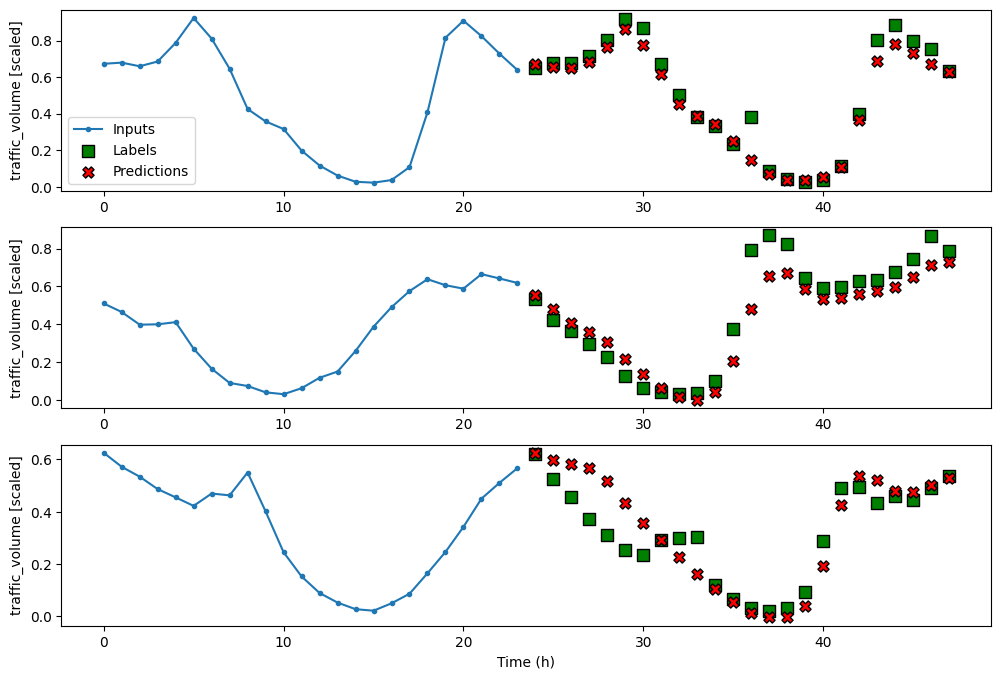

In [22]:
multi_window.plot(ms_lstm_model)

*Predicting the traffic volume over the next 24 hours using a multi-step LSTM model. We can
see some discrepancies between the predictions and the labels. Of course, this visual inspection is not enough
to assess the performance of the model.*

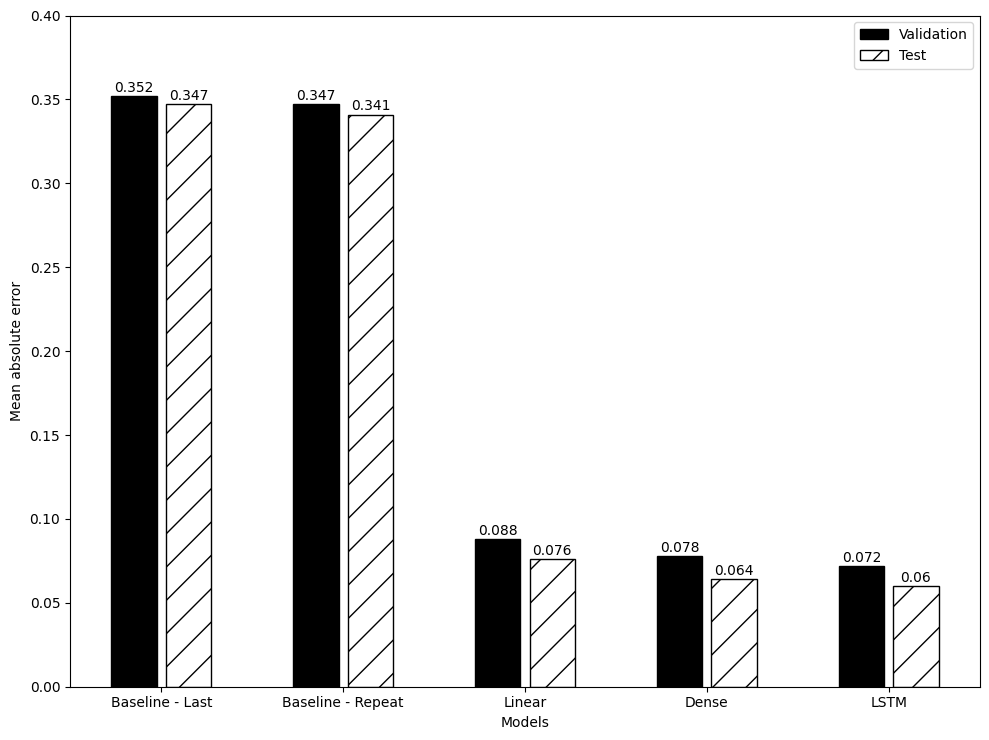

In [24]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

*The MAE of all the multi-step models built so far. Again, the LSTM is the winning model, since
it achieves the lowest MAE on both the validation and test sets.*

### Multi-output model

In [27]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [28]:
# Values from chapter 14

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [29]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)                  # We have two units because we have two targets: the temperature and the traffic volume
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 10s 15ms/step - loss: 0.0303 - mean_absolute_error: 0.1145 - val_loss: 0.0116 - val_mean_absolute_error: 0.0689
Epoch 2/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0073 - mean_absolute_error: 0.0555 - val_loss: 0.0053 - val_mean_absolute_error: 0.0465
Epoch 3/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0041 - mean_absolute_error: 0.0413 - val_loss: 0.0033 - val_mean_absolute_error: 0.0374
Epoch 4/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0031 - mean_absolute_error: 0.0355 - val_loss: 0.0025 - val_mean_absolute_error: 0.0327
Epoch 5/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0323 - val_loss: 0.0022 - val_mean_absolute_error: 0.0304
Epoch 6/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0024 - mean_absolute_error: 0.0300 - val_loss: 0.0020 - val_mean_absolute_error: 0.0286
Epoch 7/5

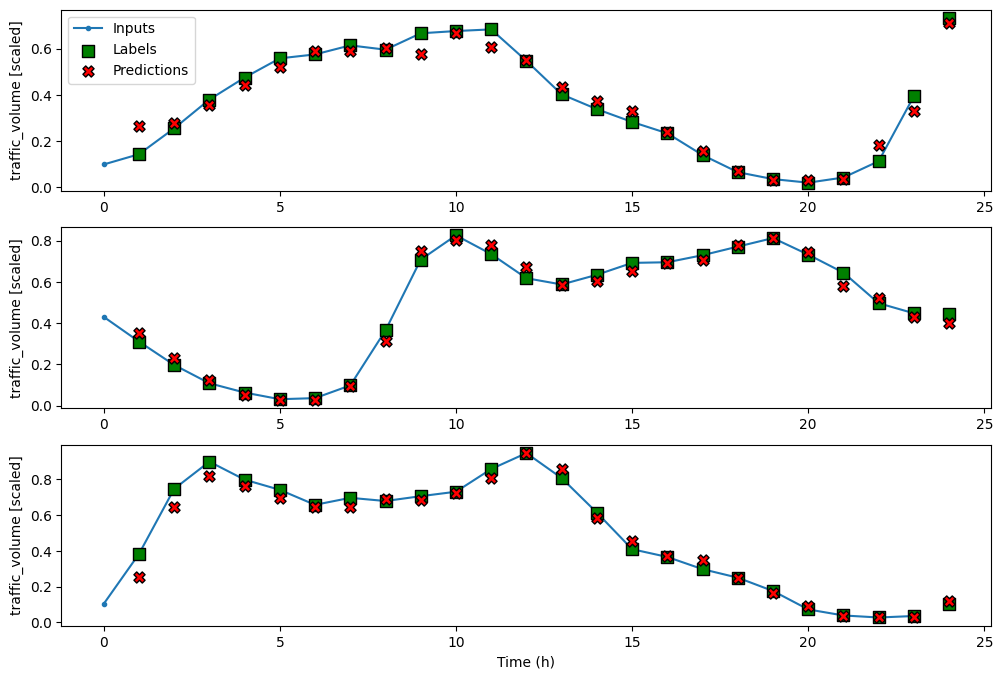

In [30]:
mo_wide_window.plot(mo_lstm_model)

*Predicting the traffic volume with an LSTM as a multi-output model. Many predictions
(shown as crosses) overlap the labels (shown as squares), suggesting very accurate predictions for the
traffic volume.*

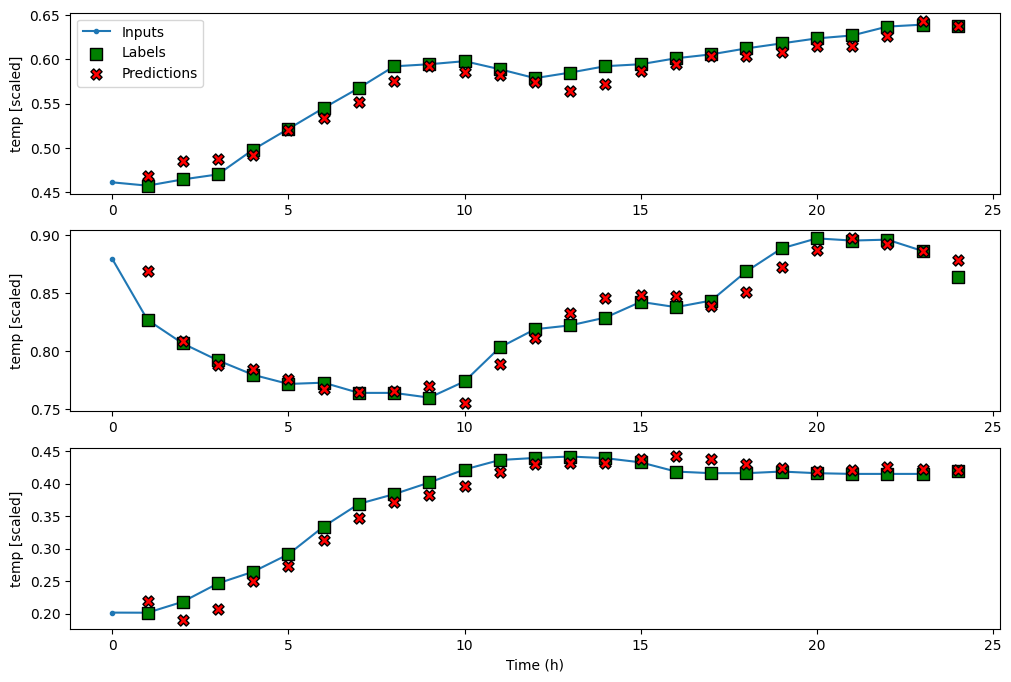

In [32]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

*Predicting the temperature using an LSTM as a multi-output model. Again, we see a lot of
overlap between the predictions (shown as crosses) and the labels (shown as squares), indicating accurate
predictions.*

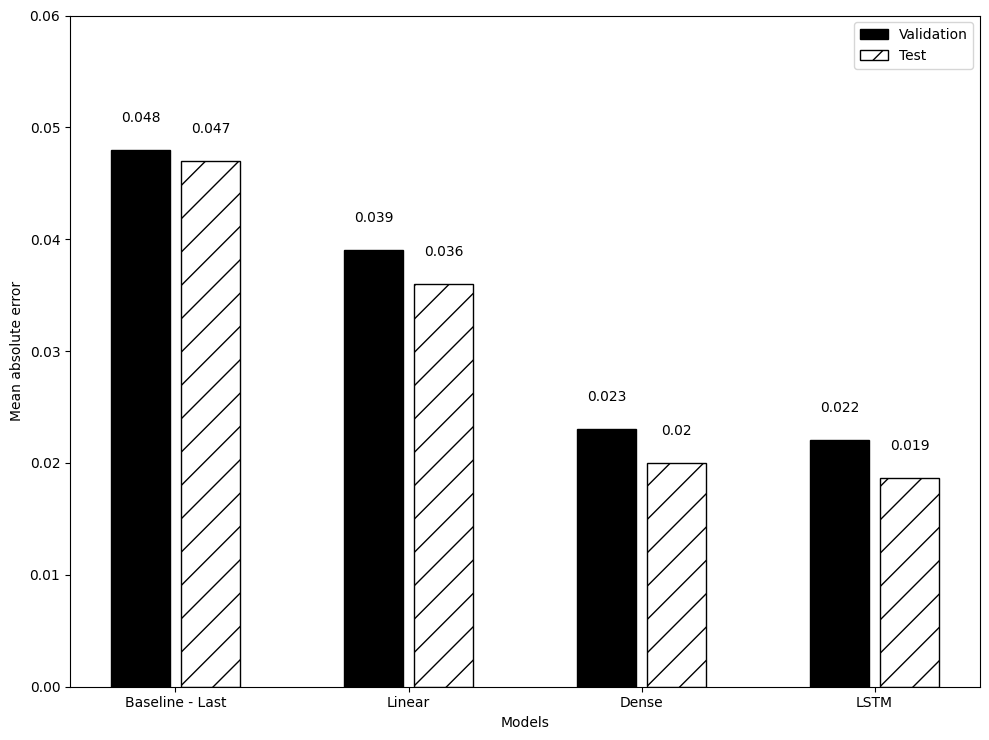

In [34]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

*The MAE of all the multi-output models built so far. Again, the winning model is the LSTM, as
it achieved the lowest MAE of all.*

#### Summary

A recurrent neural network (RNN) is a deep learning architecture especially adapted to processing sequences of data like a time series.

RNNs use a hidden state to store information in memory. However, this is only short-term memory due to the vanishing gradient problem.

Long short-term memory (LSTM) is a type of RNN that addresses the shortterm memory problem. It uses a cell state to store information for a longer time, giving the network a long memory.

The LSTM is made of three gates:

    – The forget gate determines what information from the past and present must be kept.
    – The input gate determines what information from the present must be kept.
    – The output gate uses information stored in memory to process the currentelement of a sequence.